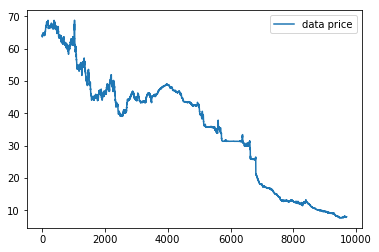

In [1]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# # Data: cleaning
# # Getting rid of NaN
# data = data.fillna(value=0.0)

# # # # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot() #x='dteday', y='cnt'
# # data[:10000].plot()

# # # data[:100].plot()
# np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data_price = np.array(data['Price'], dtype=float)
# data_price = np.array(data)
data_price.shape, data_price.dtype

plt.plot(data_price, label='data price')
plt.legend()
plt.show()

In [2]:
# test_data = np.array([[1, 2, 3]], dtype=float)
# test_data.shape, test_data.dtype
# np.mean(test_data, axis=0), test_data

# data_ = np.array(data[:, 1], dtype=float)
# data_.shape, data_.dtype
data_mean = np.mean(data_price, axis=0)
data_std = np.std(data_price, axis=0)
# std, mean, np.sqrt(np.var(data_price))
# data_norm = (data_price - mean) / std
# data_norm.dtype, data_norm.shape

# plt.plot(data_norm, label='data price norm')
# # plt.plot(data_price[:10000], label='data price')
# plt.legend()
# plt.show()

data_price_norm = (data_price - data_mean) / data_std
plt.plot(data_price_norm)
data_price_norm.mean(), data_price_norm.std(), data_price_norm.var(), data_price_norm.shape, data_price_norm.dtype

(4.6895674011185329e-17, 1.0, 1.0, (9697,), dtype('float64'))

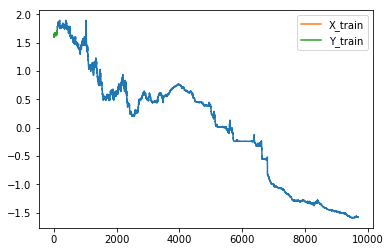

In [3]:
train_data = data_price_norm[:9000]
test_data = data_price_norm[9000:]
train_data.shape, test_data.shape
X_train = train_data[0:8999]
Y_train = train_data[1:9000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100], label='X_train')
plt.plot(Y_train[:100], label='Y_train')
plt.legend()
plt.show()

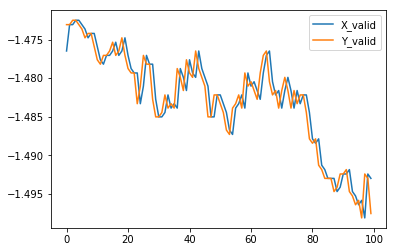

In [4]:
X_valid = test_data[0:696] 
Y_valid = test_data[1:697]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100], label='X_valid')
plt.plot(Y_valid[:100], label='Y_valid')
plt.legend()
plt.show()

In [5]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m, train): # This can be used for training & testing
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        if train: # is True
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, 
                     hh_tanh_cache, y_cache, do_cache)
        else:
            cache = None

        return y, h, cache

    def backward(self, dy, dh, cache): # This is only used for training
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache = cache
        
        dh_out = dh.copy()

        dy = l.dropout_backward(dy, do_cache)
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches
    
#     def l2_regression_reg(self, model, y_pred, y_train, lam=1e-3):
#         m = y_pred.shape[0]

# #         data_loss = 0.5 * np.sum((y_train - y_pred)**2) / m
#         data_loss = 0.5 * np.sum((y_pred - y_train.reshape(-1, 1))**2) / m
#         reg_loss = regularization(model, reg_type='l2', lam=lam)

#         return data_loss + reg_loss

#     def dl2_regression_reg(self, y_pred, y_train):
#         m = y_pred.shape[0]

#         grad_y = y_pred - y_train.reshape(-1, 1)
#         grad_y /= m

#         return grad_y

    def l2_regression(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        data_loss = 0.5 * np.sum((y_pred - y_train.reshape(-1, 1))**2) / m # number of dimensions

        return data_loss

    def dl2_regression(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2 or (aX-b)^2
        dy = (y_pred - y_train.reshape(-1, 1)) / m # number of dimensions

        return dy

#     def l1_regression(self, model, y_pred, y_train, lam=1e-3):
#         m = y_pred.shape[0]

#         data_loss = np.sum(np.abs(y_train - y_pred)) / m
#         reg_loss = regularization(model, reg_type='l2', lam=lam)

#         return data_loss + reg_loss


#     def dl1_regression(self, y_pred, y_train):
#         m = y_pred.shape[0]

#         grad_y = np.sign(y_pred - y_train.reshape(-1, 1))
#         grad_y /= m

#         return grad_y
                             
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += self.l2_regression(y_pred=y, y_train=Y)
            dy = self.dl2_regression(y_pred=y, y_train=Y)
#             loss += self.l2_regression_reg(model=self.model[0], y_pred=y, y_train=Y)
#             dy = self.dl2_regression_reg(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [24]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, alpha, mb_size, n_iter, print_after, XY_valid):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            # def loss_function(self, y_pred, y_train):
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini)
            grads = nn.train_backward(dys, caches)            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)
                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))
                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Validation loss to avoid overfitting & underfitting
        # Prediction or predicted sequence
        ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
        valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid)
        nn.losses['valid'].append(valid_loss)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))
#             print('Iter-{}, train loss: {:.4f}'.format(iter, loss))

    return nn

In [9]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = 1 # X_train.shape[1] #len(char_to_idx) # vocab_size = len(char_to_idx)
# np.random.binomial(1, 1., size=5) # / p_dropout
p_dropout = 0.8 # dropout = 1- keep_prob, p = 1-q

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), alpha=alpha, mb_size=time_step, n_iter=n_iter,
         print_after=print_after, XY_valid=(X_valid, Y_valid))

Iter-1, train loss: 2.19083898, valid loss: 0.89680559
Iter-2, train loss: 3.26844405, valid loss: 3.95084300
Iter-3, train loss: 1.11689519, valid loss: 22.75332382
Iter-4, train loss: 3.26111571, valid loss: 15.85650781
Iter-5, train loss: 3.27265703, valid loss: 11.40326467
Iter-6, train loss: 1.08866679, valid loss: 1.90963581
Iter-7, train loss: 0.00024636, valid loss: 0.60543868
Iter-8, train loss: 4.35430182, valid loss: 0.66716452
Iter-9, train loss: 0.00024993, valid loss: 0.81836020
Iter-10, train loss: 2.17498329, valid loss: 0.45604415
Iter-11, train loss: 0.00018661, valid loss: 0.81734254
Iter-12, train loss: 1.09272409, valid loss: 3.69640930
Iter-13, train loss: 1.08687360, valid loss: 2.45568694
Iter-14, train loss: 2.17695214, valid loss: 1.84156023
Iter-15, train loss: 3.26665251, valid loss: 0.87871284
Iter-16, train loss: 3.26607612, valid loss: 7.73144045
Iter-17, train loss: 2.17944805, valid loss: 2.95178888
Iter-18, train loss: 0.00030565, valid loss: 7.3397456

Iter-147, train loss: 1.09108459, valid loss: 13.41992857
Iter-148, train loss: 2.18024347, valid loss: 12.71594792
Iter-149, train loss: 1.08688409, valid loss: 18.96448110
Iter-150, train loss: 2.17854730, valid loss: 14.22620128
Iter-151, train loss: 2.18000584, valid loss: 15.40161766
Iter-152, train loss: 0.00023685, valid loss: 13.02800967
Iter-153, train loss: 2.17410909, valid loss: 16.43799414
Iter-154, train loss: 4.35766521, valid loss: 16.30925851
Iter-155, train loss: 2.17849920, valid loss: 13.42471294
Iter-156, train loss: 4.35261101, valid loss: 15.98896428
Iter-157, train loss: 0.00024767, valid loss: 16.40050392
Iter-158, train loss: 2.18000265, valid loss: 13.95176038
Iter-159, train loss: 1.08687142, valid loss: 16.31752596
Iter-160, train loss: 3.26580132, valid loss: 20.44171559
Iter-161, train loss: 2.17326587, valid loss: 13.51800926
Iter-162, train loss: 3.26935156, valid loss: 12.60174409
Iter-163, train loss: 3.26596278, valid loss: 17.14543473
Iter-164, trai

Iter-290, train loss: 2.17852939, valid loss: 6.58707027
Iter-291, train loss: 3.26423133, valid loss: 0.91699644
Iter-292, train loss: 2.17506317, valid loss: 6.60602498
Iter-293, train loss: 1.08844870, valid loss: 0.50361942
Iter-294, train loss: 2.17509571, valid loss: 1.97636114
Iter-295, train loss: 3.26509406, valid loss: 0.67106966
Iter-296, train loss: 2.17342273, valid loss: 1.39294667
Iter-297, train loss: 1.08766244, valid loss: 1.01171212
Iter-298, train loss: 2.17929749, valid loss: 0.51774134
Iter-299, train loss: 2.18014678, valid loss: 0.45855076
Iter-300, train loss: 3.26501710, valid loss: 1.83943741
Iter-301, train loss: 3.26666500, valid loss: 0.58271012
Iter-302, train loss: 1.09102886, valid loss: 1.92661428
Iter-303, train loss: 1.08846886, valid loss: 0.89558903
Iter-304, train loss: 4.35508736, valid loss: 0.65131072
Iter-305, train loss: 1.09099649, valid loss: 0.45545153
Iter-306, train loss: 2.17934694, valid loss: 2.31214256
Iter-307, train loss: 2.1801491

Iter-433, train loss: 1.08681715, valid loss: 10.15424298
Iter-434, train loss: 1.08587722, valid loss: 3.14030425
Iter-435, train loss: 2.17760900, valid loss: 6.68311743
Iter-436, train loss: 0.00012758, valid loss: 4.10348748
Iter-437, train loss: 1.09097855, valid loss: 5.28692150
Iter-438, train loss: 1.08752702, valid loss: 2.82413897
Iter-439, train loss: 2.17420247, valid loss: 8.48128455
Iter-440, train loss: 3.26590040, valid loss: 9.36897481
Iter-441, train loss: 1.08687990, valid loss: 14.98578689
Iter-442, train loss: 3.26506595, valid loss: 10.33360857
Iter-443, train loss: 3.26508679, valid loss: 14.43554666
Iter-444, train loss: 2.17932606, valid loss: 21.78673573
Iter-445, train loss: 2.17674791, valid loss: 14.22092374
Iter-446, train loss: 1.08848701, valid loss: 26.55133194
Iter-447, train loss: 2.17847325, valid loss: 27.07984790
Iter-448, train loss: 3.27014088, valid loss: 28.62307641
Iter-449, train loss: 1.08763215, valid loss: 11.55352175
Iter-450, train loss:

Iter-577, train loss: 1.08757793, valid loss: 3.37047401
Iter-578, train loss: 1.09096293, valid loss: 1.40078630
Iter-579, train loss: 1.08589778, valid loss: 1.24097052
Iter-580, train loss: 3.27095406, valid loss: 1.20241676
Iter-581, train loss: 2.17504535, valid loss: 1.74365113
Iter-582, train loss: 1.08759463, valid loss: 1.24682203
Iter-583, train loss: 3.26586524, valid loss: 1.50800241
Iter-584, train loss: 2.17587326, valid loss: 6.38388824
Iter-585, train loss: 0.00010398, valid loss: 3.55814523
Iter-586, train loss: 2.17843795, valid loss: 2.49371279
Iter-587, train loss: 2.17840163, valid loss: 2.78834038
Iter-588, train loss: 3.26756929, valid loss: 0.90483229
Iter-589, train loss: 2.18176682, valid loss: 2.22246346
Iter-590, train loss: 2.17841478, valid loss: 1.45319899
Iter-591, train loss: 3.26753049, valid loss: 1.81466582
Iter-592, train loss: 2.17504321, valid loss: 2.48462195
Iter-593, train loss: 0.00007842, valid loss: 3.25581059
Iter-594, train loss: 1.0875607

Iter-720, train loss: 2.18342229, valid loss: 576.52289537
Iter-721, train loss: 1.09092822, valid loss: 218.20952775
Iter-722, train loss: 1.08753342, valid loss: 123.70083606
Iter-723, train loss: 1.08748748, valid loss: 158.87758065
Iter-724, train loss: 3.26243038, valid loss: 308.33881684
Iter-725, train loss: 2.17412208, valid loss: 50.51442327
Iter-726, train loss: 3.26915555, valid loss: 192.41383038
Iter-727, train loss: 4.35832074, valid loss: 55.43476675
Iter-728, train loss: 0.00003597, valid loss: 94.34843504
Iter-729, train loss: 2.17748881, valid loss: 53.07076597
Iter-730, train loss: 2.17663639, valid loss: 226.74749496
Iter-731, train loss: 1.08580047, valid loss: 63.97747034
Iter-732, train loss: 3.26667546, valid loss: 85.23642569
Iter-733, train loss: 3.27091619, valid loss: 50.50558066
Iter-734, train loss: 2.17506148, valid loss: 221.23360590
Iter-735, train loss: 2.17761187, valid loss: 95.20083806
Iter-736, train loss: 1.08762044, valid loss: 669.15848042
Iter-

Iter-860, train loss: 0.00002623, valid loss: 234.62494277
Iter-861, train loss: 0.00005051, valid loss: 88.32380165
Iter-862, train loss: 1.08749271, valid loss: 307.34091572
Iter-863, train loss: 2.17411562, valid loss: 190.10158499
Iter-864, train loss: 2.18003157, valid loss: 409.03975554
Iter-865, train loss: 2.17329604, valid loss: 346.30680730
Iter-866, train loss: 1.09265629, valid loss: 484.63219670
Iter-867, train loss: 2.18012993, valid loss: 385.13393085
Iter-868, train loss: 2.17847636, valid loss: 633.17531957
Iter-869, train loss: 4.35418503, valid loss: 578.50985156
Iter-870, train loss: 1.08676732, valid loss: 1009.91829440
Iter-871, train loss: 2.17415786, valid loss: 770.77572457
Iter-872, train loss: 3.26669238, valid loss: 783.68640506
Iter-873, train loss: 1.09093713, valid loss: 932.97512171
Iter-874, train loss: 0.00007364, valid loss: 776.66768742
Iter-875, train loss: 2.17587422, valid loss: 786.19397510
Iter-876, train loss: 2.17587609, valid loss: 671.949781

Iter-1000, train loss: 1.09085849, valid loss: 723.04839334


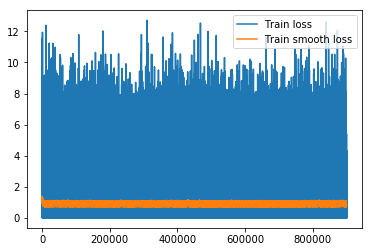

In [10]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

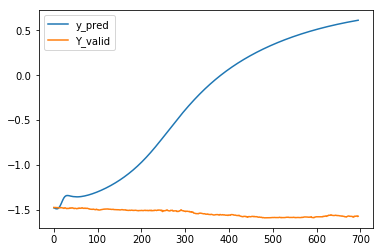

In [13]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred, label='y_pred')
plt.plot(Y_valid, label='Y_valid')
# plt.plot(X_valid, label='X_valid')
plt.legend()
plt.show()